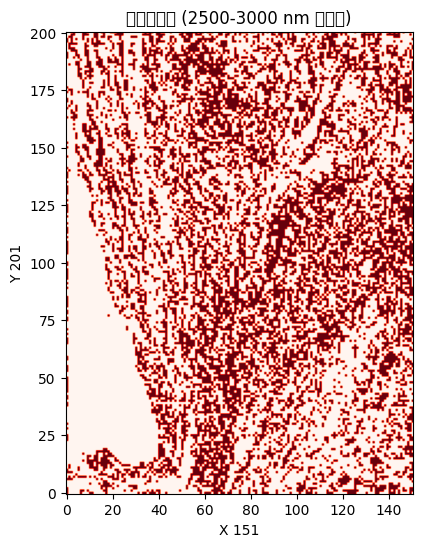

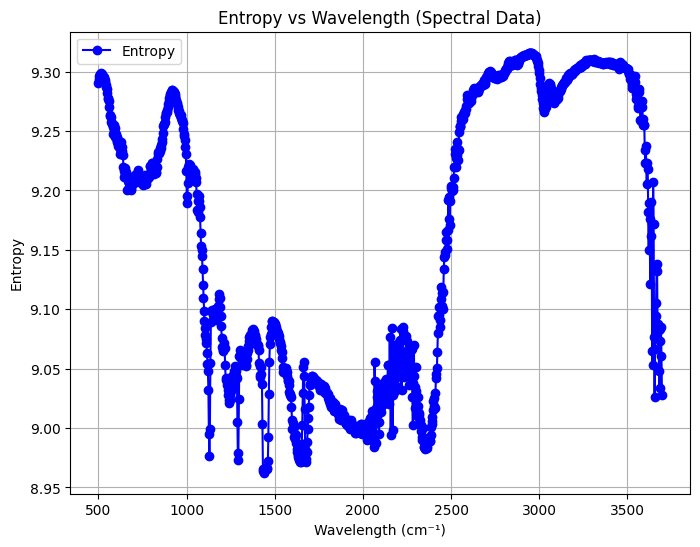

In [13]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from my_func.Read_ibw import read_ibw

# SVDを全ての波長に対して行う関数
def apply_svd_to_all_wavenumbers(data, k):
    """
    データ全体に対してSVDを適用し、ノイズ除去を行う
    data: 4次元データ (x, y, z, wavelength)
    k: 上位k個の特異値を保持
    """
    reshaped_data = data[:, :, 0, :].reshape(-1, data.shape[3])  # (x*y, wavelength) の2次元に変換
    U, S, Vt = svd(reshaped_data, full_matrices=False)

    # 上位k個の特異値を使ってデータを再構築
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]
    S_k_matrix = np.diag(S_k)

    # 再構築
    reconstructed_data = np.dot(U, np.dot(S_k_matrix, Vt))
    reconstructed_data = reconstructed_data.reshape(data[:, :, 0, :].shape)

    return reconstructed_data

# 情報エントロピー計算の関数
def calculate_entropy_each_wavelength(spectra):
    """各波長における情報エントロピーを計算"""
    spectra = np.abs(spectra)  # スペクトルの強度は絶対値を使用
    prob_distribution = spectra / np.sum(spectra, axis=0, keepdims=True)  # 確率分布に正規化
    entropy = -np.nansum(prob_distribution * np.log(prob_distribution + 1e-12), axis=0)  # 各波長ごとのエントロピー計算
    return entropy

# エントロピープロットの関数
def plot_entropy_vs_wavelength(wavelengths, entropy_values):
    """波長と情報エントロピーの関係をプロット"""
    plt.figure(figsize=(8, 6))
    plt.plot(wavelengths, entropy_values, marker='o', linestyle='-', color='b', label='Entropy')
    plt.title('Entropy vs Wavelength (Spectral Data)')
    plt.xlabel('Wavelength (cm⁻¹)')
    plt.ylabel('Entropy')
    plt.grid(True)
    plt.legend()
    plt.show()

# データの読み込み
data = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw')
# 波長軸を最後の次元に移動
data = np.moveaxis(data, 0, -1)  # 新しい形状: (151, 201, 1, 1148)

# 波長データの読み込み
wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

# 上位特異値の数を指定
k = 5

# SVDを全波長に対して適用してノイズ除去
reconstructed_data = apply_svd_to_all_wavenumbers(data, k)

# 閾値に基づくマスクの作成
min_wavelength = 2500  # 最小波長（nm）
max_wavelength = 3000  # 最大波長（nm）
wavelength_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))[0]

# マスク作成のための強度の総和
intensity_sum = np.sum(reconstructed_data[:, :, wavelength_indices], axis=-1)
threshold = 60
mask = intensity_sum > threshold

# マスクされた点のスペクトルを取り出し、そのエントロピーを計算
mask_indices = np.where(mask)  # マスクされた座標を取得
masked_spectra = reconstructed_data[mask_indices[0], mask_indices[1], :]  # マスクされたスペクトルを取得

# マスク結果の表示
plt.figure(figsize=(8, 6))
plt.imshow(mask.T, cmap='Reds', origin='lower')
plt.title(f'マスク結果 ({min_wavelength}-{max_wavelength} nm の範囲)')
plt.xlabel('X 151')
plt.ylabel('Y 201')
plt.show()

# 各波長ごとのエントロピーを計算
entropy_values = calculate_entropy_each_wavelength(masked_spectra)

# 情報エントロピー vs 波長のプロット
plot_entropy_vs_wavelength(wavelengths, entropy_values)
